In [66]:
import numpy as np
import pandas as pd
import scipy.linalg as sla
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.linear_model import LinearRegression, Lasso, Ridge

In [67]:
class MyLinearRegression:
    def __init__(self, fit_intercept=True):
        self.fit_intercept = fit_intercept
    
    def fit(self, X, y):
        # Принимает на вход X, y и вычисляет веса по данной выборке
        # Не забудьте про фиктивный признак равный 1

        n, k = X.shape

        X_train = X
        if self.fit_intercept:
            X_train = np.hstack((X, np.ones((n, 1))))
        
        self.w = np.linalg.inv(X_train.T @ X_train) @ X_train.T @ y

        return self
    
    def predict(self, X):
        # Принимает на вход X и возвращает ответы модели
        # Не забудьте про фиктивный признак равный 1
        n, k = X.shape
        if self.fit_intercept:
            X_train = np.hstack((X, np.ones((n, 1))))
        
        y_pred = X_train @ self.w

        return y_pred
    
    def get_weights(self):
        return self.w


In [68]:
from sklearn.model_selection import train_test_split

In [69]:
def linear_expression(x):
    return 5 * x + 6

In [70]:
# по признакам сгенерируем значения таргетов с некоторым шумом
objects_num = 50
X = np.linspace(-5, 5, objects_num)
y = linear_expression(X) + np.random.randn(objects_num) * 5

# выделим половину объектов на тест
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5)

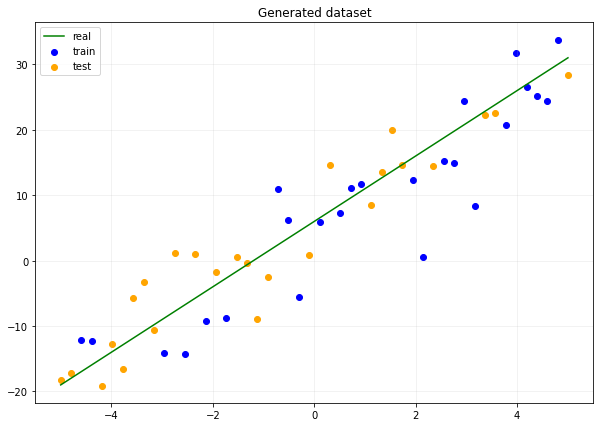

In [71]:
plt.figure(figsize=(10, 7))
plt.plot(X, linear_expression(X), label='real', c='g')
plt.scatter(X_train, y_train, label='train', c='b')
plt.scatter(X_test, y_test, label='test', c='orange')

plt.title('Generated dataset')
plt.grid(alpha=0.2)
plt.legend()
plt.show()


In [72]:
regressor = MyLinearRegression()

regressor.fit(X_train[:, np.newaxis], y_train)

prediction = regressor.predict(X_test[:, np.newaxis])
w = regressor.get_weights()
w

array([4.79789383, 4.07667614])

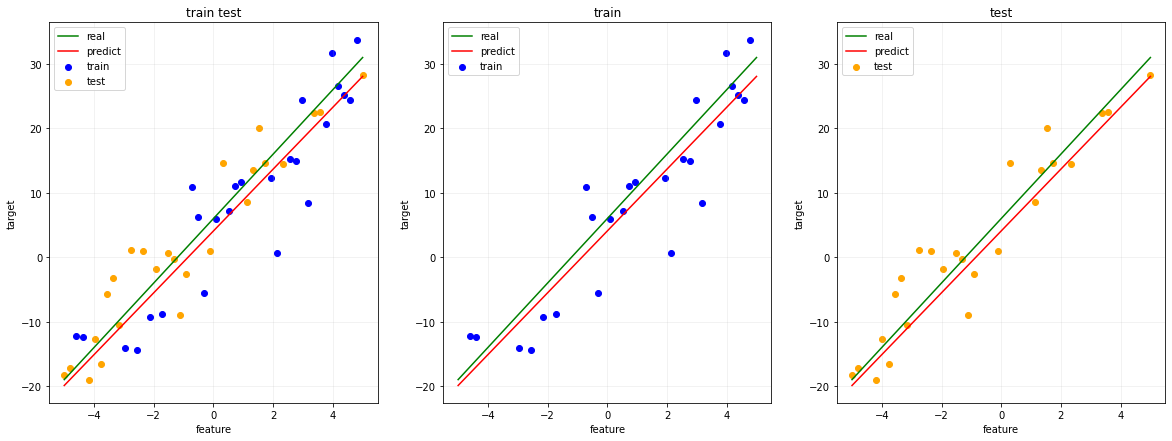

In [73]:
plt.figure(figsize=(20, 7))

ax = None

for i, types in enumerate([['train', 'test'], ['train'], ['test']]):
    ax = plt.subplot(1, 3, i + 1, sharey=ax)
    if 'train' in types:
        plt.scatter(X_train, y_train, label='train', c='b')
    if 'test' in types:
        plt.scatter(X_test, y_test, label='test', c='orange')
    
    plt.plot(X, linear_expression(X), label='real', c='g')
    plt.plot(X, regressor.predict(X[:, np.newaxis]), label='predict', c='r')

    plt.ylabel('target')
    plt.xlabel('feature')
    plt.title(' '.join(types))
    plt.grid(alpha=0.2)
    plt.legend()

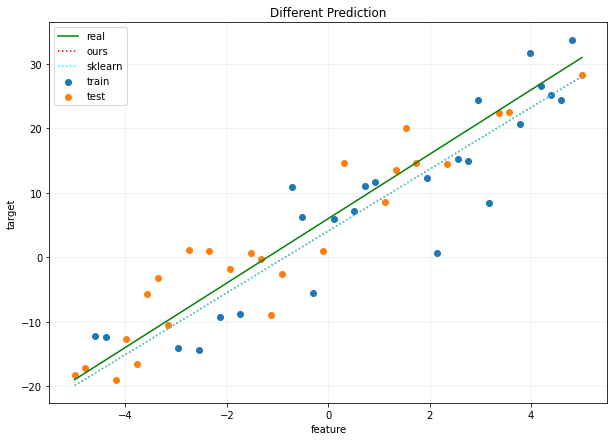

In [74]:
sk_reg = LinearRegression().fit(X_train[:, np.newaxis], y_train)

plt.figure(figsize=(10, 7))
plt.plot(X, linear_expression(X), label='real', c='g')

plt.scatter(X_train, y_train, label='train')
plt.scatter(X_test, y_test, label='test')
plt.plot(X, regressor.predict(X[:, np.newaxis]), label='ours', c='r', linestyle=':')
plt.plot(X, sk_reg.predict(X[:, np.newaxis]), label='sklearn', c='cyan', linestyle=':')

plt.title('Different Prediction')
plt.ylabel('target')
plt.xlabel('feature')
plt.grid(alpha=0.2)
plt.legend()
plt.show()

In [75]:
from sklearn.metrics import mean_squared_error

train_predictions = regressor.predict(X_train[:, np.newaxis])
test_predictions = regressor.predict(X_test[:, np.newaxis])

print('Train MSE: ', mean_squared_error(y_train, train_predictions))
print('Test MSE: ', mean_squared_error(y_test, test_predictions))

Train MSE:  33.591866292502594
Test MSE:  24.45015117138645


In [76]:
class MyGradientLinearRegression(MyLinearRegression):
    def __init__(self, **kwargs):
        super().__init__(**kwargs) # передает именный параметры родительскому конструктору
        self.w = None
    
    def fit(self, X, y, lr=0.01, max_iter=100):
        # Принимает на вход X, y и вычисляет веса по данной выборке
        # Не забудьте про фиктивный признак равный 1!

        n, k = X.shape

        # случайно инициализируем веса
        if self.w is None:
            self.w = np.random.randn(k + 1 if self.fit_intercept else k)
        
        X_train = np.hstack((X, np.ones((n, 1)))) if self.fit_intercept else X

        self.losses = []

        for item_num in range(max_iter):
            y_pred = self.predict(X)
            self.losses.append(mean_squared_error(y_pred, y))

            grad = self._calc_gradient(X_train, y, y_pred)

            assert grad.shape == self.w.shape, f'gradient shape {grad.shape} is not equal weight shape {self.w.shape}'
            self.w -= lr * grad
        
        return self
    
    def _calc_gradient(self, X, y, y_pred):
        grad = 2 * (y_pred - y)[:, np.newaxis] * X
        grad = grad.mean(axis=0)
        return grad
    
    def get_losses(self):
        return self.losses

In [77]:
regressor = MyGradientLinearRegression(fit_intercept=True)

l = regressor.fit(X_train[:, np.newaxis], y_train, max_iter=100).get_losses()

predictions = regressor.predict(X_test[:, np.newaxis])
w = regressor.get_weights()

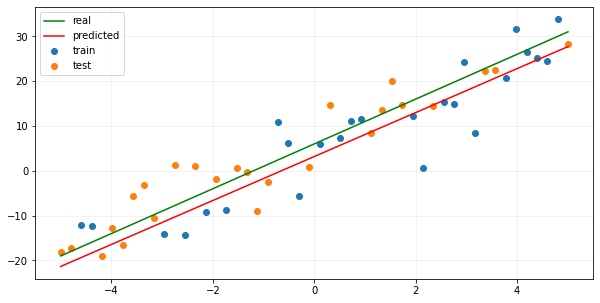

In [78]:
plt.figure(figsize=(10, 5))
plt.plot(X, linear_expression(X), label='real', c='g')

plt.scatter(X_train, y_train, label='train')
plt.scatter(X_test, y_test, label='test')
plt.plot(X, regressor.predict(X[:, np.newaxis]), label='predicted', c='r')

plt.grid(alpha=0.2)
plt.legend()
plt.show()

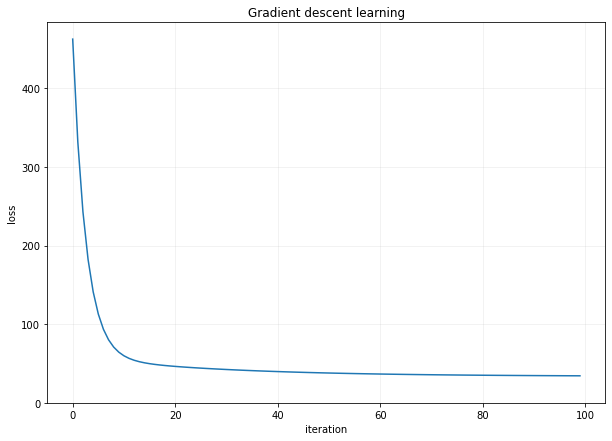

In [79]:
plt.figure(figsize=(10, 7))

plt.plot(l)

plt.title('Gradient descent learning')
plt.ylabel('loss')
plt.xlabel('iteration')
plt.ylim(bottom=0)
plt.grid(alpha=0.2)

plt.show()

In [80]:
class MySGDLinearRegression(MyGradientLinearRegression):
    def __init__(self, n_sample=10, **kwargs):
        super().__init__(**kwargs) # передает именный параметры родительскому конструктору
        self.w = None
        self.n_sample = n_sample
    
    def _calc_gradient(self, X, y, y_pred):
        # Главное отличие в SGD - это использование подвыборки для шага оптимизации
        inds = np.random.choice(np.arange(X.shape[0]), size=self.n_sample, replace=False)

        grad = 2 * (y_pred[inds] - y[inds])[:, np.newaxis] * X[inds]
        grad = grad.mean(axis=0)

        return grad

In [81]:
regressor = MySGDLinearRegression(fit_intercept=True)

l = regressor.fit(X_train[:, np.newaxis], y_train, max_iter=100).get_losses()

predictions = regressor.predict(X_test[:, np.newaxis])
w = regressor.get_weights()

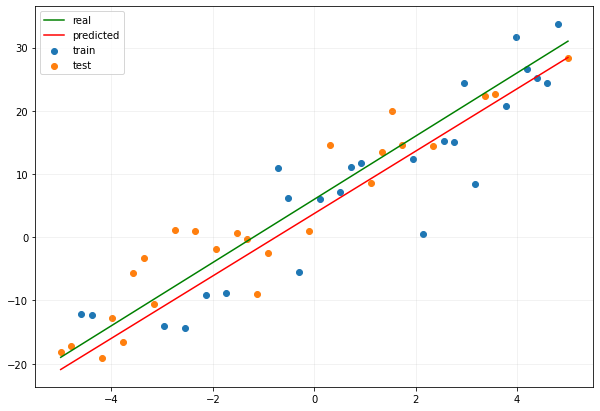

In [82]:
plt.figure(figsize=(10, 7))
plt.plot(X, linear_expression(X), label='real', c='g')

plt.scatter(X_train, y_train, label='train')
plt.scatter(X_test, y_test, label='test')
plt.plot(X, regressor.predict(X[:, np.newaxis]), label='predicted', c='r')

plt.grid(alpha=0.2)
plt.legend()
plt.show()

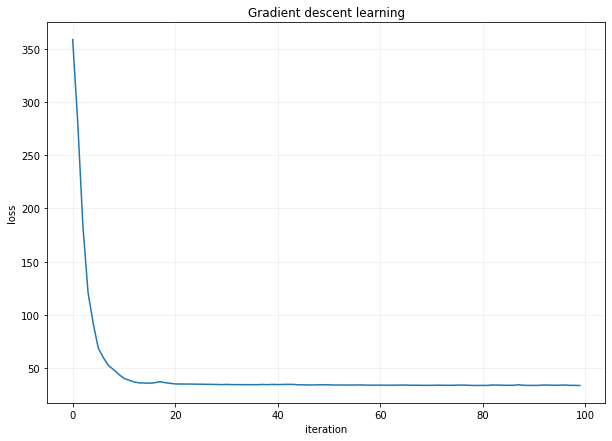

In [83]:
plt.figure(figsize=(10, 7))

plt.plot(l)

plt.title('Gradient descent learning')
plt.ylabel('loss')
plt.xlabel('iteration')
plt.grid(alpha=0.2)
plt.show()

In [84]:
n_samples = [1, 2, 4]

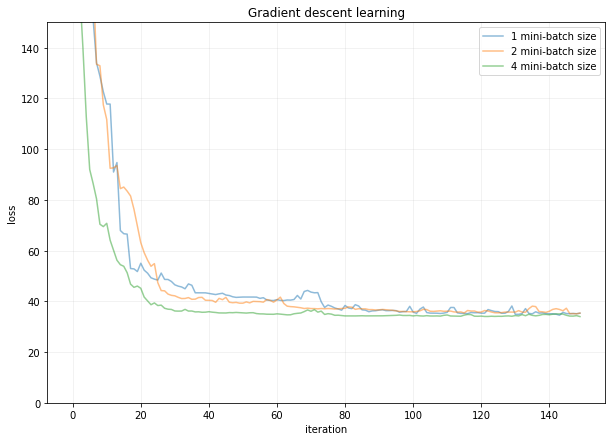

In [85]:
plt.figure(figsize=(10, 7))

for ns in n_samples:
    l = MySGDLinearRegression(fit_intercept=True, n_sample=ns).fit(
        X_train[:, np.newaxis],
        y_train,
        lr=5e-3,
        max_iter=150,
    ).get_losses()
    plt.plot(l, alpha=0.5, label=f'{ns} mini-batch size')

plt.title('Gradient descent learning')
plt.ylabel('loss')
plt.xlabel('loss')
plt.xlabel('iteration')

plt.legend()
plt.ylim((0, 150))
plt.grid(alpha=0.2)
plt.show()

In [86]:
def logit(x, w):
    return np.dot(x, w)

def sigmoid(h):
    return 1. / (1 + np.exp(-h))

class MyLogisticRegression(object):
    def __init__(self):
        self.w = None
    
    def fit(self, X, y, max_iter=100, lr=0.1):
        # Принимает на вход X, y и вычисляет веса по данной выборке.
        # Множество допустимых классов: {1, -1}
        # Не забудьте про фиктивный признак равный 1!

        n, k = X.shape

        if self.w is None:
            self.w = np.random.randn(k + 1)
        
        X_train = np.concatenate((np.ones((n, 1)), X), axis=1)

        losses = []

        for iter_num in range(max_iter):
            z = sigmoid(logit(X_train, self.w))
            grad = np.dot(X_train.T, (z - y)) / len(y)

            self.w -= grad * lr

            losses.append(self.__loss(y, z))
            
        return losses
    
    def predict_proba(self, X):
        # Принимает на вход X и возвращает ответы модели
        n, k = X.shape
        X_ = np.concatenate((np.ones((n, 1)), X), axis=1)
        return sigmoid(logit(X_, self.w))
    
    def predict(self, X, threshold=0.5):
        return self.predict_proba(X) >= threshold
    
    def get_weights(self):
        return self.w
    
    def __loss(self, y, p):
        p = np.clip(p, 1e-10, 1 - 1e-10)
        return np.mean(y * np.log(p) + (1 - y) * np.log(1 - p))

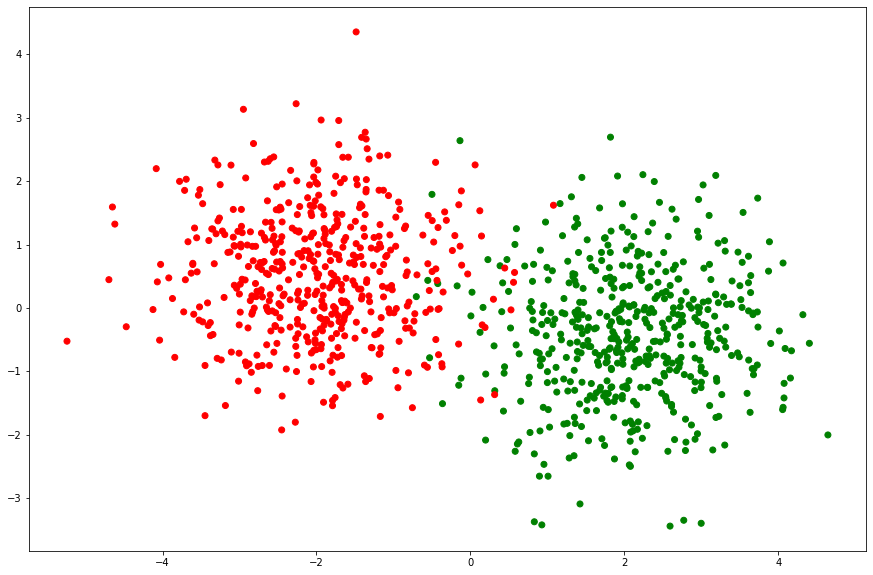

In [87]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=1000, centers=[[-2, 0.5], [2, -0.5]], cluster_std=1, random_state=42)

colors = ('red', 'green')
colored_y = np.zeros(y.size, dtype=str)

for i, cl in enumerate([0, 1]):
    colored_y[y == cl] = str(colors[i])

plt.figure(figsize=(15,10))
plt.scatter(X[:, 0], X[:, 1], c=colored_y)
plt.show()

In [88]:
clf = MyLogisticRegression()

clf.fit(X, y, max_iter=1000)

w = clf.get_weights()

<ipython-input-89-9b6e8895871e>:14: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, z, cmap=cmap_light)


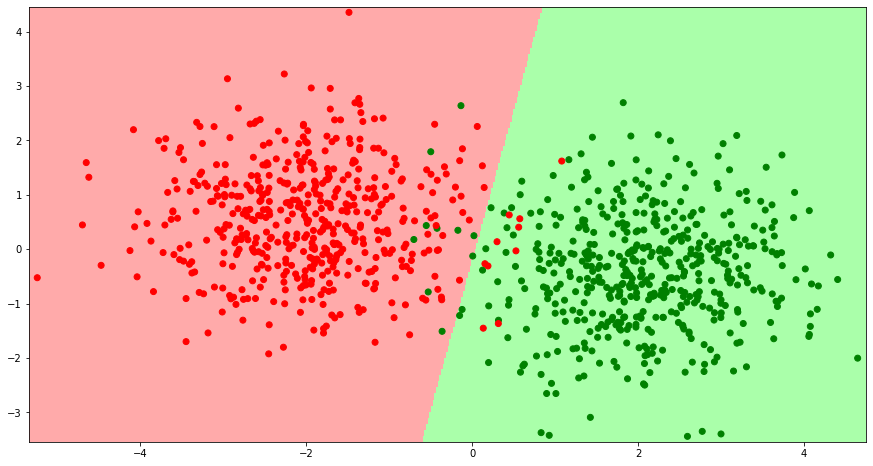

In [89]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

plt.figure(figsize=(15, 8))

eps = 0.1
xx, yy = np.meshgrid(np.linspace(np.min(X[:, 0]) - eps, np.max(X[:, 0]) + eps, 500),
                     np.linspace(np.min(X[:, 1]) - eps, np.max(X[:, 1]) + eps, 500))

z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

z = z.reshape(xx.shape)

cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA'])
plt.pcolormesh(xx, yy, z, cmap=cmap_light)

plt.scatter(X[:, 0], X[:, 1], c=colored_y)

<ipython-input-90-76e44207e1c8>:12: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, Z, cmap=plt.get_cmap('viridis'))


<function matplotlib.pyplot.colorbar(mappable=None, cax=None, ax=None, **kw)>

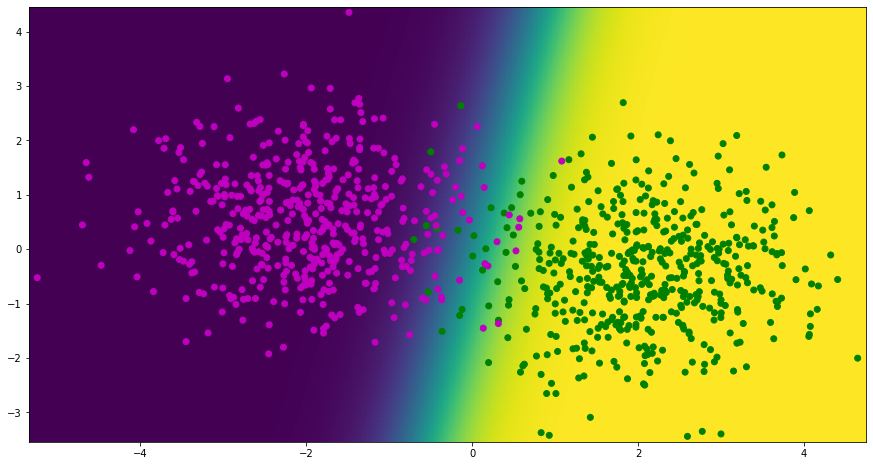

In [90]:
colors = ('magenta', 'green')
colored_y = np.zeros(y.size, dtype=str)

for i, cl in enumerate([0, 1]):
    colored_y[y == cl] = str(colors[i])

plt.figure(figsize=(15,8))

Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap=plt.get_cmap('viridis'))

plt.scatter(X[:, 0], X[:, 1], c=colored_y)
plt.colorbar

In [91]:
objects_num = 50
X = np.linspace(-8, 8, objects_num)
y = linear_expression(X) + np.random.randn(objects_num) * 5

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5)

In [92]:
reg = Ridge(alpha=1).fit(np.hstack((X, X, X))[:, np.newaxis], np.hstack((y, y, y)))
np.append(reg.coef_, reg.intercept_)

array([5.00403543, 6.90478355])

In [93]:
reg = Ridge(alpha=1/3).fit(X[:, np.newaxis], y)
np.append(reg.coef_, reg.intercept_)

array([5.00403543, 6.90478355])

In [94]:
class MyRidgeRegression(MyLinearRegression):
    def __init__(self, alpha=1.0, **kwargs):
        super().__init__(**kwargs)
        self.alpha = alpha
    
    def fit(self, X, y):
        n, m = X.shape
        X_train = X

        if self.fit_intercept:
            X_train = np.hstack((X, np.ones((n, 1))))
        
        lambdaI = self.alpha * np.eye(X_train.shape[1])
        if self.fit_intercept:
            lambdaI[-1, -1] = 0

        self.w = np.linalg.inv(X_train.T @ X_train + lambdaI) @ X_train.T @ y

        return self

    def get_weights(self):
        return self.w

In [95]:
alpha = 1.0
regressor = MyRidgeRegression(alpha=alpha).fit(X_train[:, np.newaxis], y_train)

In [96]:
sklearn_reg = Ridge(alpha).fit(X_train[:, np.newaxis], y_train)
assert np.allclose(regressor.get_weights(), np.append(sklearn_reg.coef_, sklearn_reg.intercept_))
regressor.get_weights()

array([4.98493727, 7.32716095])

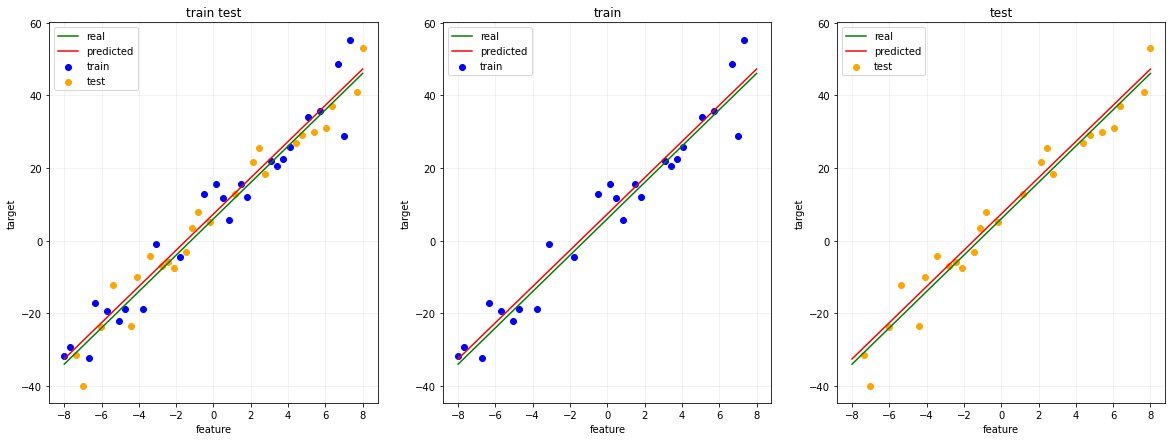

In [97]:
plt.figure(figsize=(20, 7))

ax = None

for i, types in enumerate([['train', 'test'], ['train'], ['test']]):
    ax = plt.subplot(1, 3, i + 1, sharey=ax)
    if 'train' in types:
        plt.scatter(X_train, y_train, label='train', c='b')
    if 'test' in types:
        plt.scatter(X_test, y_test, label='test', c='orange')

    plt.plot(X, linear_expression(X), label='real', c='g')
    plt.plot(X, regressor.predict(X[:, np.newaxis]), label='predicted', c='r')

    plt.ylabel('target')
    plt.xlabel('feature')
    plt.title(" ".join(types))
    plt.grid(alpha=0.2)
    plt.legend()

plt.show()

In [98]:
class MySGDRidge(MySGDLinearRegression):
    def __init__(self, alpha=1.0, **kwargs):
        super().__init__(**kwargs) # передает именные параметры родительскому конструктору
        self.w = None
        self.alpha = alpha

    def _calc_gradient(self, X, y, y_pred):
        # Главное отличие в SGD - это использование подвыборки для шага оптимизации
        inds = np.random.choice(np.arange(X.shape[0]), size=self.n_sample, replace=False)

        lambdaI = self.alpha * np.eye(self.w.shape[0])
        if self.fit_intercept:
            lambdaI[-1, -1] = 0

        grad = 2 * (X[inds].T @ X[inds] / self.n_sample + lambdaI) @ self.w
        grad -= 2 * X[inds].T @ y[inds] / self.n_sample

        return grad

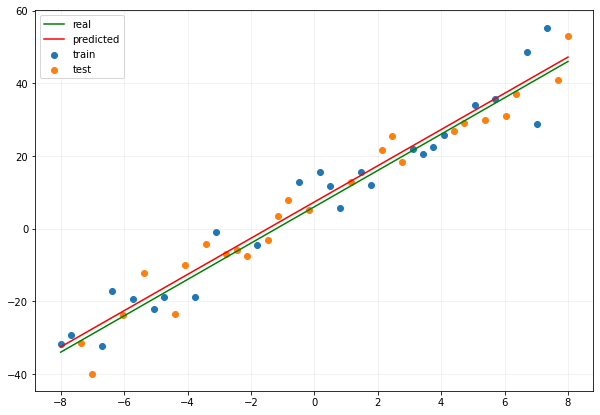

In [99]:
plt.figure(figsize=(10, 7))
plt.plot(X, linear_expression(X), label='real', c='g')

plt.scatter(X_train, y_train, label='train')
plt.scatter(X_test, y_test, label='test')
plt.plot(X, regressor.predict(X[:, np.newaxis]), label='predicted', c='r')

plt.grid(alpha=0.2)
plt.legend()
plt.show()

In [101]:
regressor = MySGDRidge(alpha=1, n_sample=20).fit(X[:, np.newaxis], y, max_iter=1000, lr=0.01)
l = regressor.get_losses()
regressor.get_weights()

array([4.87383885, 6.93698822])

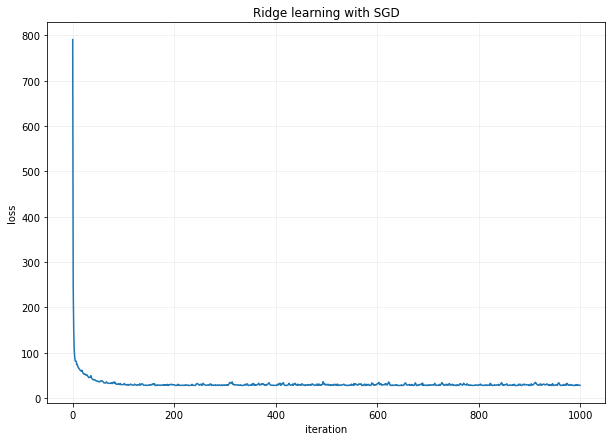

In [102]:
plt.figure(figsize=(10, 7))

plt.plot(l)

plt.title('Ridge learning with SGD')
plt.ylabel('loss')
plt.xlabel('iteration')
plt.grid(alpha=0.2)
plt.show()

In [103]:
reg = Lasso(alpha=1).fit(np.hstack((X, X, X))[:, np.newaxis], np.hstack((y, y, y)))
np.append(reg.coef_, reg.intercept_)

array([4.96050111, 6.90478355])

In [104]:
reg = Lasso(alpha=1).fit(X[:, np.newaxis], y)
np.append(reg.coef_, reg.intercept_)

array([4.96050111, 6.90478355])

In [105]:
def soft_sign(x, eps=1e-7):
    if abs(x) > eps:
        return np.sign(x)
    return x / eps

np_soft_sign = np.vectorize(soft_sign)

class MySGDLasso(MySGDLinearRegression):
    def __init__(self, alpha=1.0, **kwargs):
        super().__init__(**kwargs) # передает именные параметры родительскому конструктору
        self.w = None
        self.alpha = alpha

    def _calc_gradient(self, X, y, y_pred):
        # Главное отличие в SGD - это использование подвыборки для шага оптимизации
        inds = np.random.choice(np.arange(X.shape[0]), size=self.n_sample, replace=False)

        signw = np_soft_sign(self.w)
        if self.fit_intercept:
            signw[-1] = 0

        grad = X[inds].T @ (y_pred[inds] - y[inds])[:, np.newaxis] / self.n_sample
        grad += self.alpha * signw[:, np.newaxis]

        return grad.flatten()

In [106]:
regressor = MySGDLasso(alpha=1, n_sample=4).fit(X[:, np.newaxis], y, max_iter=1000, lr=0.01)
l = regressor.get_losses()
regressor.get_weights()

array([4.72159922, 7.02996063])

In [107]:
sklearn_reg = Lasso().fit(X[:, np.newaxis], y)
np.append(sklearn_reg.coef_, sklearn_reg.intercept_)

array([4.96050111, 6.90478355])

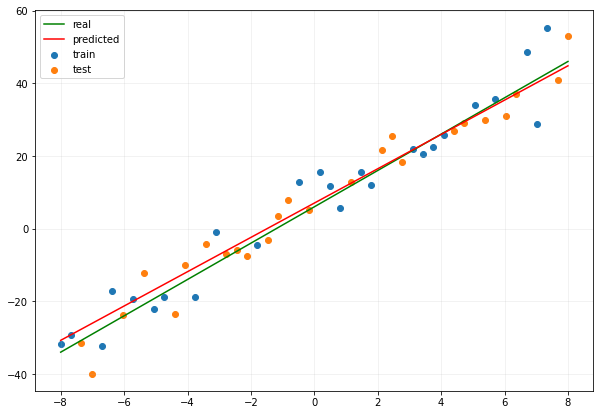

In [108]:
plt.figure(figsize=(10, 7))
plt.plot(X, linear_expression(X), label='real', c='g')

plt.scatter(X_train, y_train, label='train')
plt.scatter(X_test, y_test, label='test')
plt.plot(X, regressor.predict(X[:, np.newaxis]), label='predicted', c='r')

plt.grid(alpha=0.2)
plt.legend()
plt.show()

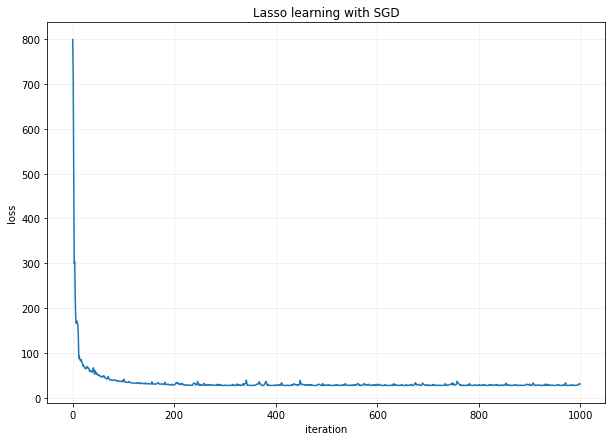

In [109]:
plt.figure(figsize=(10, 7))

plt.plot(l)

plt.title('Lasso learning with SGD')
plt.ylabel('loss')
plt.xlabel('iteration')
plt.grid(alpha=0.2)
plt.show()

In [110]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

import pandas as pd
import seaborn as sns

In [111]:
iris = load_iris()

In [112]:
data = pd.DataFrame(data=np.hstack([iris.data, iris.target[:, np.newaxis]]), 
                    columns=iris.feature_names + ['target'])

names = data.columns
data.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


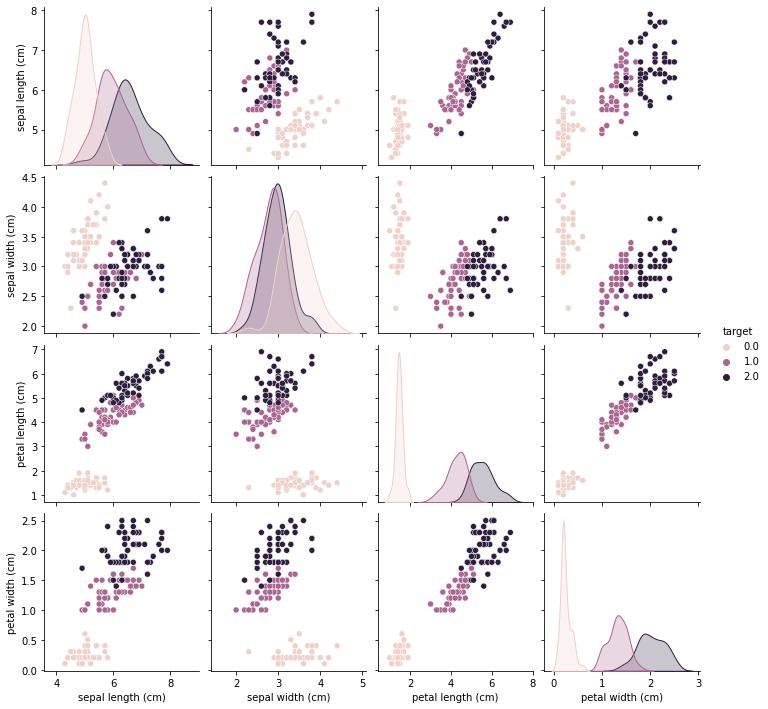

In [113]:
sns.pairplot(data, hue='target')

plt.show()

In [114]:
X_train, X_test, y_train, y_test = train_test_split(data[names[:-1]], data[names[-1]])

In [115]:
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, f1_score

In [125]:
cls = make_pipeline(
    StandardScaler(),
    LogisticRegression(C=2)
)
cls = cls.fit(X_train.to_numpy(), y_train)
preds_train = cls.predict(X_train)

accuracy_score(preds_train, y_train), f1_score(preds_train, y_train, average='macro')

(0.9732142857142857, 0.9725202333897988)

In [126]:
preds_test = cls.predict(X_test)

accuracy_score(preds_test, y_test), f1_score(preds_test, y_test, average='macro')

(1.0, 1.0)

In [127]:
# cls.coef_, cls.intercept_
cls[1].coef_, cls[1].intercept_

(array([[-1.17017298,  1.44631147, -2.03980514, -1.96202647],
        [ 0.74994755, -0.4814785 , -0.40360459, -1.08754865],
        [ 0.42022542, -0.96483297,  2.44340973,  3.04957512]]),
 array([ 0.1377345 ,  2.31691513, -2.45464962]))

<ipython-input-128-1a191af26e55>:17: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, Z, cmap=cmap_light)


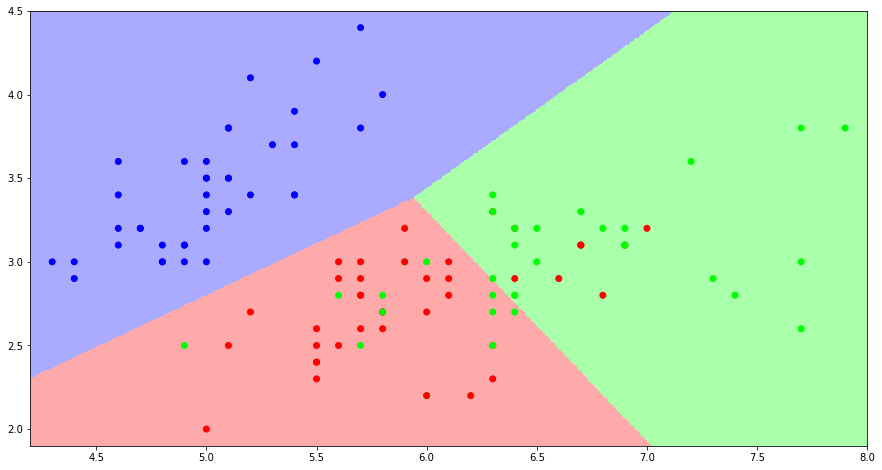

In [128]:
from matplotlib.colors import ListedColormap

plt.figure(figsize=(15,8))

eps = 0.1
xx, yy = np.meshgrid(np.linspace(np.min(X_train[names[0]]) - eps, np.max(X_train[names[0]]) + eps, 500),
                     np.linspace(np.min(X_train[names[1]]) - eps, np.max(X_train[names[1]]) + eps, 500))



cls.fit(X_train[names[:2]], y_train)
Z = cls.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)

cmap_light = ListedColormap(['#AAAAFF', '#FFAAAA', '#AAFFAA'])
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

plt.scatter(X_train[names[0]], X_train[names[1]], c=y_train, cmap='brg')